# Exploratory Analysis of GSE164378 Dataset

## Overview
This notebook performs a comprehensive single-cell RNA-seq analysis of the GSE164378 dataset using Scanpy. The dataset contains PBMC (Peripheral Blood Mononuclear Cells) data with both 3' and 5' gene expression profiling, along with antibody-derived tags (ADT) and hashtag oligonucleotides (HTO).

## Dataset Source
This dataset is from the research paper:

**"Integrated analysis of multimodal single-cell data"**  
*Hao et al., Cell (2021)*  
DOI: [10.1016/j.cell.2021.04.048](https://doi.org/10.1016/j.cell.2021.04.048)  
Paper URL: https://www.cell.com/cell/fulltext/S0092-8674(21)00583-3  
GEO Accession: [GSE164378](https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE164378)

### Key Contributions of the Paper:
- Introduced **weighted-nearest neighbor (WNN)** analysis for integrating multimodal single-cell data
- Demonstrated integration of RNA-seq with surface protein measurements (CITE-seq)
- Identified previously unreported lymphoid subpopulations in human PBMCs
- Provided a comprehensive framework for analyzing multi-omic single-cell datasets

## Analysis Pipeline
The analysis follows the standard single-cell RNA-seq workflow:
1. **Data Loading**: Import 10X Genomics format data and associated metadata
2. **Quality Control**: Filter low-quality cells and genes based on QC metrics
3. **Normalization**: Normalize counts and identify highly variable genes
4. **Dimensionality Reduction**: PCA and UMAP for visualization
5. **Clustering**: Leiden algorithm for unsupervised cell clustering
6. **Visualization**: Generate plots to explore cell types and marker genes

## Requirements
- **Environment**: `sc-multiomics` conda environment (Python 3.11)
- **Setup**: `conda env create -f environment.yml && conda activate sc-multiomics`
- **Packages**: scanpy, pandas, matplotlib, seaborn (all via conda)

In [ ]:
# Import required libraries
import os
import scanpy as sc
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

# Import dataset download utilities
from download_geo_dataset import ensure_dataset_available, check_dataset_exists

# Configure matplotlib to display plots inline
%matplotlib inline

# Configure Scanpy settings
sc.settings.verbosity = 3  # Show informative messages (0=errors, 1=warnings, 2=info, 3=hints)
sc.logging.print_header()  # Print versions of key packages

# Set plotting parameters for high-quality figures
sc.settings.set_figure_params(
    dpi=120,              # Resolution
    facecolor='white',    # Background color
    frameon=False,        # Remove plot frame
    vector_friendly=True, # Use vector graphics when possible
    fontsize=12           # Base font size
)

# Define directory paths
ACCESSION = "GSE164378"                      # GEO accession number
DATA_DIR = Path("data") / ACCESSION / "suppl"  # Raw data location
RESULTS_DIR = Path("results") / ACCESSION    # Output directory
FIGURES_DIR = RESULTS_DIR / "figures"        # Figure output directory

# Create output directories if they don't exist
RESULTS_DIR.mkdir(parents=True, exist_ok=True)
FIGURES_DIR.mkdir(exist_ok=True)

# Check if dataset is available, download if necessary
print(f"\n{'='*60}")
print(f"Checking dataset availability...")
print(f"{'='*60}")

if not check_dataset_exists(ACCESSION):
    print(f"\n⚠️  Dataset {ACCESSION} not found locally.")
    print(f"   The data files need to be downloaded from GEO.")
    print(f"\n   Please run the following command to download:")
    print(f"   python download_geo_dataset.py")
    print(f"\n   Or download manually from:")
    print(f"   https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc={ACCESSION}")
    print(f"\n   Then run this notebook again.")
    raise FileNotFoundError(f"Dataset {ACCESSION} not found. Please download first.")
else:
    print(f"✅ Dataset {ACCESSION} found at: {DATA_DIR.parent.absolute()}")
    print(f"   Ready to proceed with analysis!")

/home/steve/miniconda3/envs/genentech/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


scanpy==1.10.3 anndata==0.10.9 umap==0.5.9.post2 numpy==2.0.2 scipy==1.13.1 pandas==2.3.3 scikit-learn==1.6.1 statsmodels==0.14.5 igraph==1.0.0 leidenalg==0.11.0 pynndescent==0.5.13


In [2]:
print(f"\n{'='*60}")
print(f"Starting analysis of GSE164378")
print(f"Data directory: {DATA_DIR.absolute()}")
print(f"Results directory: {RESULTS_DIR.absolute()}")
print(f"{'='*60}\n")


Starting analysis of GSE164378
Data directory: /home/steve/Projects/genentech/pbmc-multimodal-analysis/data/GSE164378/suppl
Results directory: /home/steve/Projects/genentech/pbmc-multimodal-analysis/results/GSE164378



## 1. Load Data

In this section, we load the single-cell RNA-seq data from the GSE164378 dataset. The data is in 10X Genomics format, which consists of three files:
- **barcodes.tsv.gz**: Cell barcodes (one per cell)
- **features.tsv.gz**: Gene names and IDs
- **matrix.mtx.gz**: Sparse count matrix (genes × cells)

We also load the metadata file that contains cell-level annotations including cell types, batch information, and other experimental variables. The metadata is joined with the count matrix to create a comprehensive AnnData object.

In [3]:
print("Loading 3' RNA sequencing data...")
# Read 10X Genomics format data
# The files have prefixes like 'GSM5008737_RNA_3P-' for the 3' gene expression data
adata = sc.read_10x_mtx(
    DATA_DIR,
    prefix='GSM5008737_RNA_3P-',
    gex_only=False  # Keep all features including ADT if mixed (though here they are separate)
)

# Load metadata containing cell-level annotations
print("Loading metadata...")
metadata_path = DATA_DIR / "GSE164378_sc.meta.data_3P.csv.gz"
metadata = pd.read_csv(metadata_path, index_col=0)

# Align metadata with the count matrix
# We take the intersection of cell barcodes to ensure consistency
common_cells = adata.obs_names.intersection(metadata.index)
print(f"Found {len(common_cells)} cells in both matrix and metadata.")

# Subset to common cells and merge metadata
adata = adata[common_cells].copy()
adata.obs = adata.obs.join(metadata)

# Ensure gene names are unique (important for downstream analysis)
adata.var_names_make_unique()

print(f"Data loaded: {adata.n_obs} cells x {adata.n_vars} genes")


Loading 3' RNA sequencing data...
--> This might be very slow. Consider passing `cache=True`, which enables much faster reading from a cache file.
Loading metadata...
Found 161764 cells in both matrix and metadata.
Data loaded: 161764 cells x 33538 genes


## 2. Quality Control & Preprocessing

Quality control is crucial for removing low-quality cells and genes that could confound downstream analysis. We perform the following steps:

### QC Metrics
- **n_genes_by_counts**: Number of genes detected per cell (cells with too few genes may be empty droplets)
- **total_counts**: Total UMI counts per cell (library size)
- **pct_counts_mt**: Percentage of mitochondrial gene expression (high values indicate dying/stressed cells)

### Filtering Thresholds
- Remove cells with < 200 detected genes (likely empty droplets or debris)
- Remove genes detected in < 3 cells (too rare to be informative)
- Remove cells with > 20% mitochondrial content (dying cells)

### Normalization
- **Total count normalization**: Scale each cell to 10,000 total counts (accounts for sequencing depth differences)
- **Log transformation**: Apply log(x+1) to stabilize variance

### Highly Variable Genes (HVGs)
We identify genes with high biological variability across cells. These genes are most informative for distinguishing cell types and are used for dimensionality reduction.


Calculating QC metrics...
Showing QC plots...


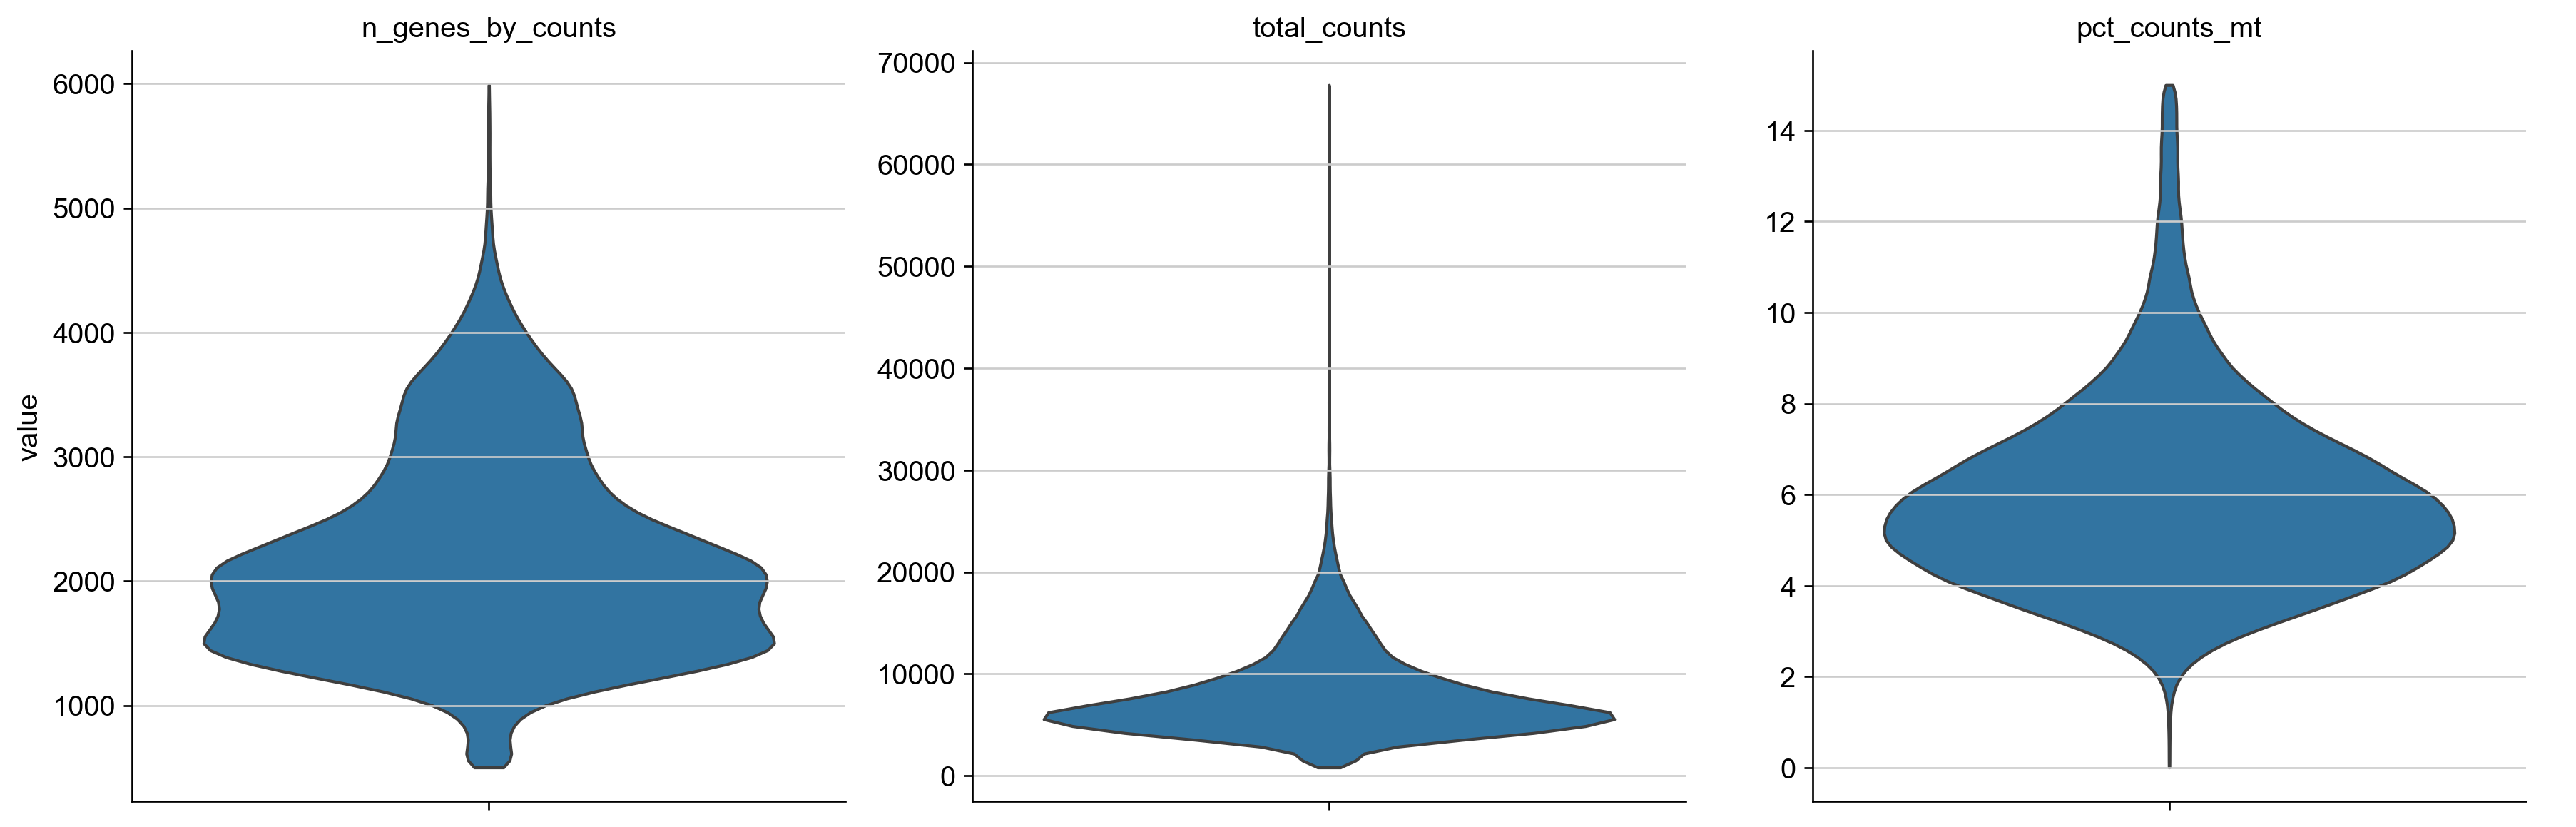

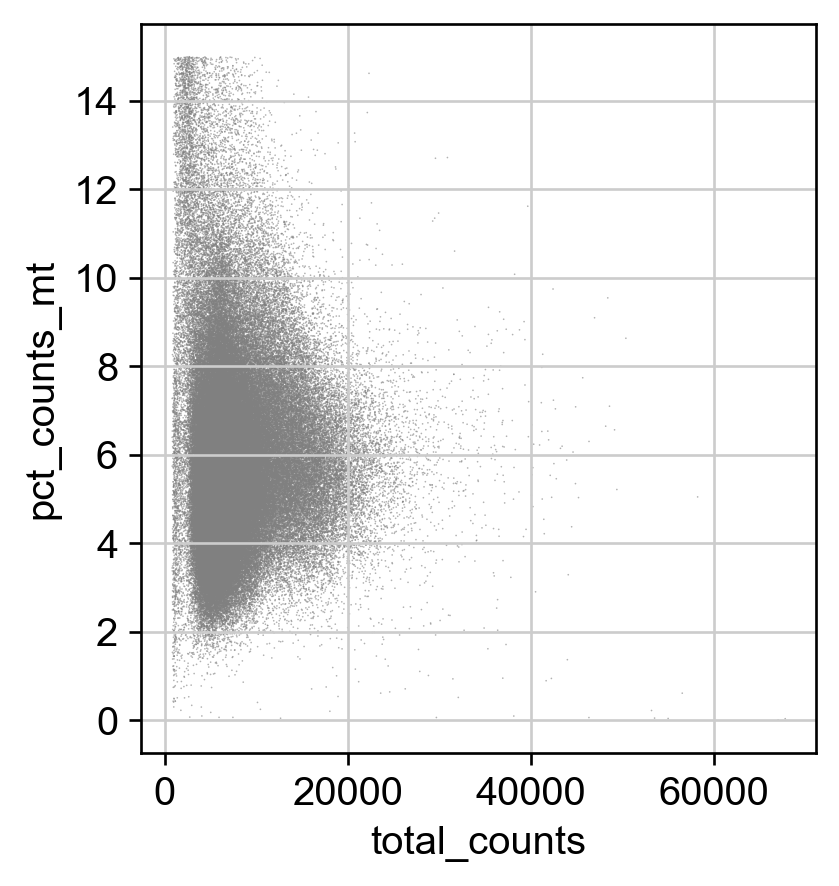

Filtering cells...
filtered out 8331 genes that are detected in less than 3 cells
Cells after filtering: 161764
Normalizing and scaling...
normalizing counts per cell
    finished (0:00:01)
extracting highly variable genes
    finished (0:00:03)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)
Identified 1580 highly variable genes


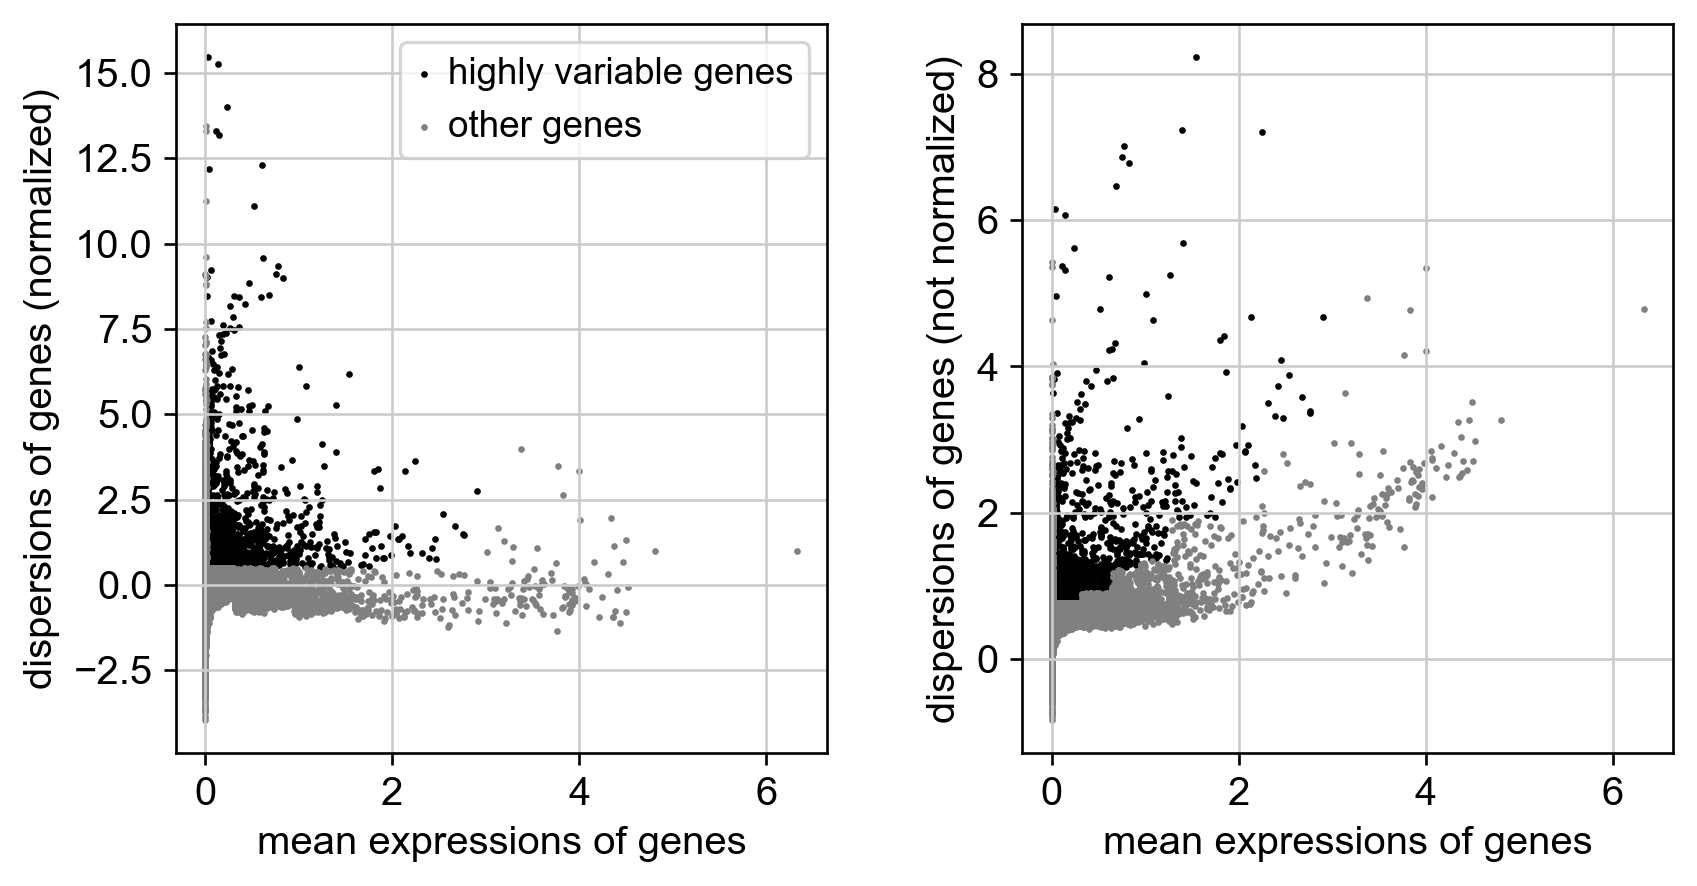

regressing out ['total_counts', 'pct_counts_mt']


/home/steve/miniconda3/envs/genentech/lib/python3.9/site-packages/scanpy/preprocessing/_simple.py:668: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


    sparse input is densified and may lead to high memory use
    finished (0:02:14)


In [4]:
print("\nCalculating QC metrics...")
# Identify mitochondrial genes (start with 'MT-' in humans)
adata.var['mt'] = adata.var_names.str.startswith('MT-')

# Calculate QC metrics for each cell
# This adds columns like n_genes_by_counts, total_counts, pct_counts_mt to adata.obs
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)

# Visualize QC metrics to identify filtering thresholds
print("Showing QC plots...")
# Violin plots show the distribution of QC metrics across all cells
sc.pl.violin(
    adata,
    ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'],
    stripplot=False,
    multi_panel=True,
    show=True  # display in notebook
)

# Scatter plot to visualize relationship between total counts and mitochondrial percentage
# High MT% with low counts often indicates dying cells
sc.pl.scatter(
    adata,
    x='total_counts',
    y='pct_counts_mt',
    size=1,
    alpha=0.6,
    show=True  # display in notebook
)

# Apply filtering thresholds based on QC metrics
print("Filtering cells...")
sc.pp.filter_cells(adata, min_genes=200)  # Remove cells with < 200 genes
sc.pp.filter_genes(adata, min_cells=3)     # Remove genes in < 3 cells
adata = adata[adata.obs.pct_counts_mt < 20, :].copy()  # Remove high-MT cells

print(f"Cells after filtering: {adata.n_obs}")

# Normalization to account for sequencing depth differences
print("Normalizing and scaling...")
adata.layers["counts"] = adata.X.copy()  # Preserve raw counts
sc.pp.normalize_total(adata, target_sum=1e4)  # Normalize to 10,000 counts per cell
sc.pp.log1p(adata)  # Log-transform: log(count + 1)

# Identify highly variable genes (HVGs)
# These genes show high variability across cells and are most informative
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)
print(f"Identified {sum(adata.var.highly_variable)} highly variable genes")

# Visualize HVG selection
sc.pl.highly_variable_genes(adata, show=True)

# Prepare data for PCA: scale HVGs and regress out technical variation
adata.raw = adata  # Store normalized data for later use (e.g., plotting gene expression)
adata = adata[:, adata.var.highly_variable]  # Subset to HVGs only
sc.pp.regress_out(adata, ['total_counts', 'pct_counts_mt'])  # Remove technical effects
sc.pp.scale(adata, max_value=10)  # Scale to unit variance, clip outliers

## 3. Dimensionality Reduction & Clustering

Single-cell datasets are high-dimensional (thousands of genes), making them difficult to visualize and analyze. We use dimensionality reduction to project cells into lower-dimensional spaces while preserving biological structure.

### Principal Component Analysis (PCA)
PCA identifies the directions of maximum variance in the data. We use the top principal components (PCs) to capture most of the biological signal while reducing noise.

### Neighborhood Graph
We construct a k-nearest neighbor (KNN) graph where cells are connected if they have similar gene expression profiles. This graph is used for both UMAP and clustering.

### UMAP (Uniform Manifold Approximation and Projection)
UMAP is a non-linear dimensionality reduction technique that preserves both local and global structure. It creates a 2D representation suitable for visualization.

### Leiden Clustering
The Leiden algorithm detects communities (clusters) in the neighborhood graph. Cells within the same cluster have similar expression profiles and likely represent the same cell type or state.


Running PCA...
computing PCA
    with n_comps=50
    finished (0:00:31)


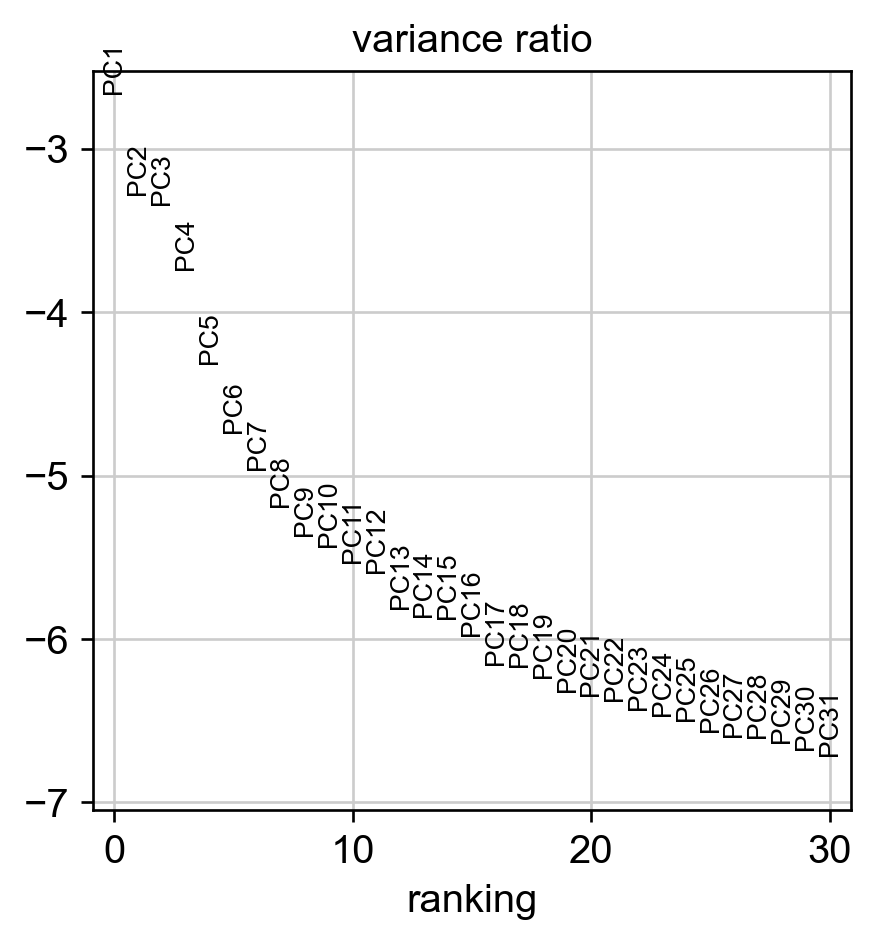

Computing neighborhood graph...
computing neighbors
    using 'X_pca' with n_pcs = 40
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:40)
Running UMAP...
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm)
    'umap', UMAP parameters (adata.uns) (0:01:06)
Running Leiden clustering...
running Leiden clustering


/tmp/ipykernel_89817/1244004607.py:28: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(adata)


    finished: found 29 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:02:29)


In [5]:
print("\nRunning PCA...")
# Perform PCA on scaled, highly variable genes
# By default, computes 50 principal components
sc.tl.pca(adata, svd_solver='arpack')

# Visualize explained variance to determine how many PCs to use
# The elbow point indicates where additional PCs contribute less information
sc.pl.pca_variance_ratio(
    adata,
    log=True,
    show=True  # show in notebook instead of saving
)

print("Computing neighborhood graph...")
# Build k-nearest neighbor graph using top 40 PCs
# n_neighbors=10: each cell connected to its 10 most similar cells
# This graph is used for UMAP and clustering
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=40)

print("Running UMAP...")
# Compute 2D UMAP embedding for visualization
# UMAP preserves local and global structure from the high-dimensional space
sc.tl.umap(adata)

print("Running Leiden clustering...")
# Perform community detection using the Leiden algorithm
# Identifies groups of cells with similar expression profiles
sc.tl.leiden(adata)


## 4. Visualization

Now we visualize the results of our analysis using UMAP plots. Each plot colors cells by different attributes to explore the data from multiple perspectives:

1. **Leiden Clusters**: Unsupervised clustering results showing distinct cell populations
2. **Cell Type Annotations (Level 1)**: Broad cell type categories from the metadata
3. **Cell Type Annotations (Level 2)**: Fine-grained cell type annotations
4. **Marker Gene Expression**: Expression of canonical PBMC marker genes:
   - **CD3E**: T cells
   - **CD4**: CD4+ T cells (helper T cells)
   - **CD8A**: CD8+ T cells (cytotoxic T cells)
   - **MS4A1** (CD20): B cells
   - **GNLY**: NK cells
   - **CD14**: Classical monocytes
   - **FCGR3A** (CD16): Non-classical monocytes
   - **PPBP**: Platelets/Megakaryocytes

In [6]:
print("\nGenerating UMAP plots...")


Generating UMAP plots...


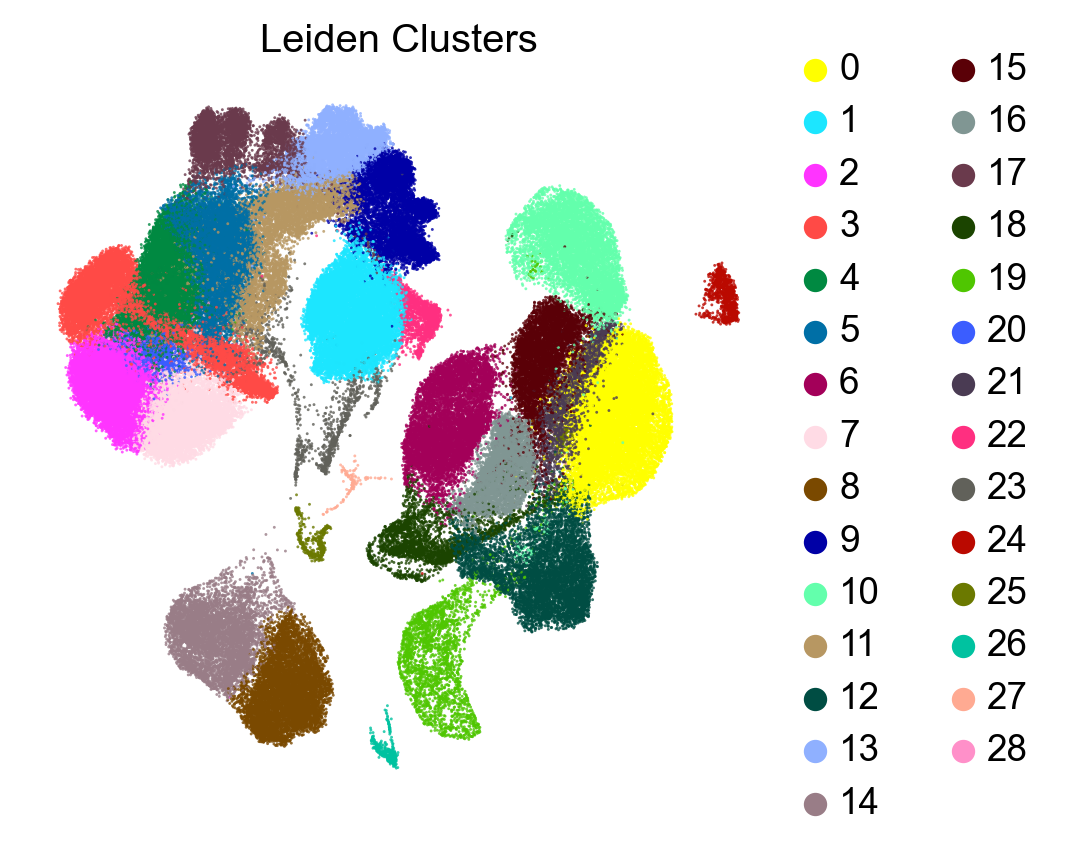

In [7]:
# Plot 1: Leiden Clusters
# Visualize unsupervised clustering results
# Each color represents a distinct cluster of cells with similar expression profiles
sc.pl.umap(
    adata,
    color=['leiden'],
    title="Leiden Clusters",
    s=3,           # point size
    alpha=0.8,     # transparency
    show=True      # display inline in notebook
)


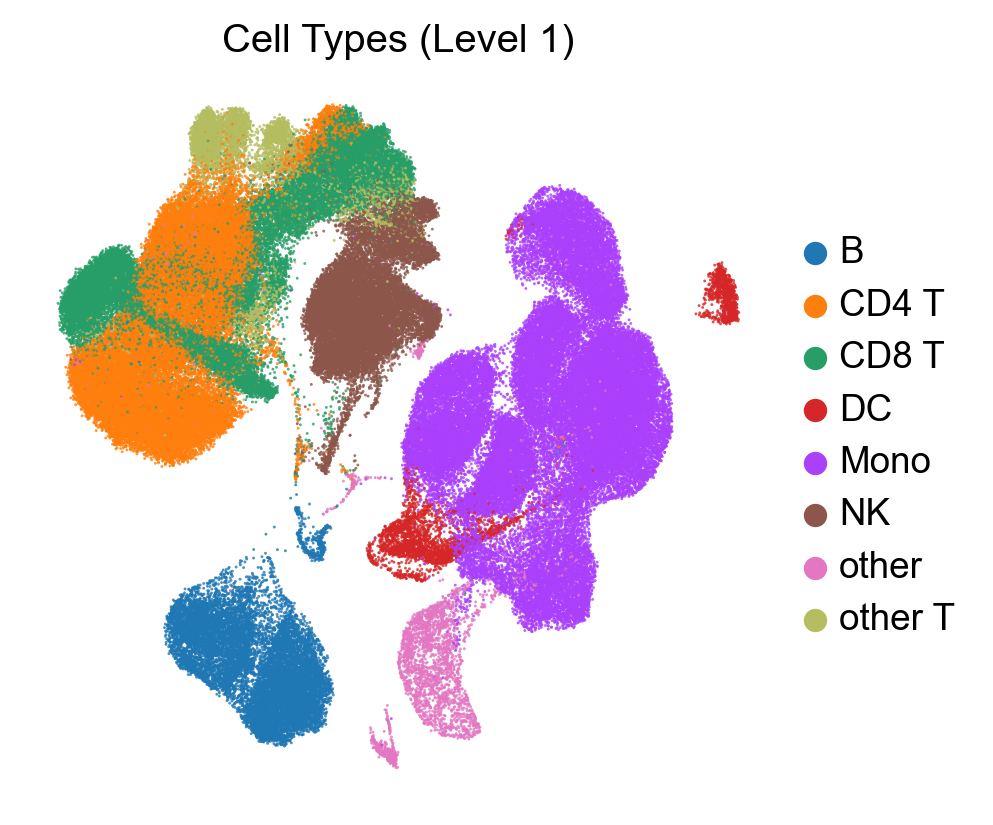

In [8]:
# Plot 2: Cell Types (Level 1)
# Display broad cell type categories from the original study's annotations
# This shows major immune cell lineages (e.g., T cells, B cells, Monocytes, NK cells)
if 'celltype.l1' in adata.obs.columns:
    sc.pl.umap(
        adata,
        color=['celltype.l1'],
        title="Cell Types (Level 1)",
        s=3,
        alpha=0.8,
        show=True  # display inline in notebook
    )

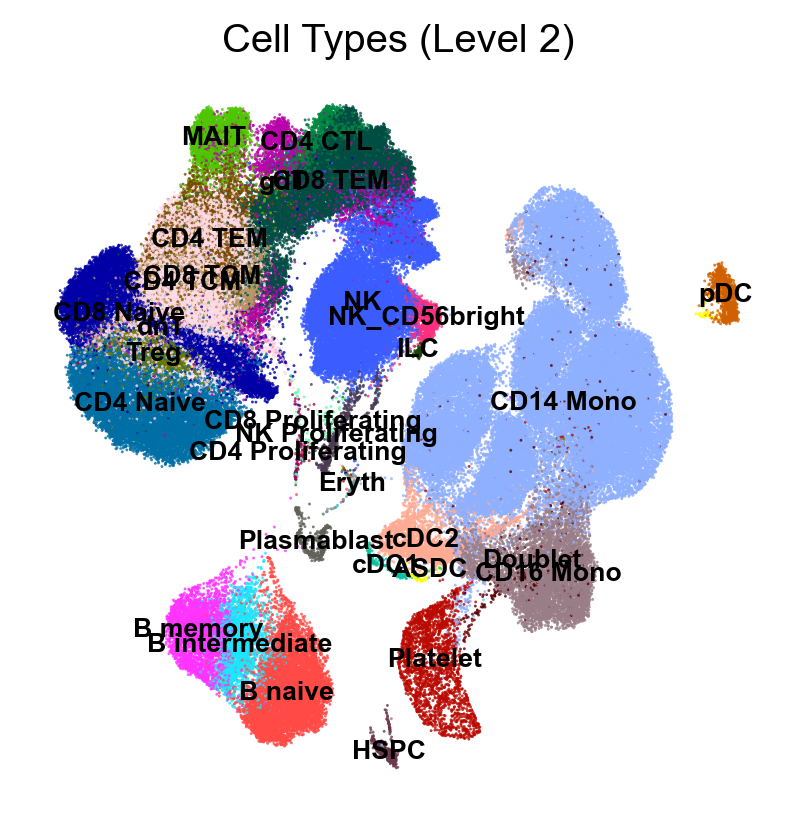

In [9]:
# Plot 3: Cell Types (Level 2)
# Display fine-grained cell type annotations with more specific subtypes
# (e.g., CD4+ naive, CD4+ memory, CD8+ naive, CD14+ monocytes, CD16+ monocytes, etc.)
if 'celltype.l2' in adata.obs.columns:
    sc.pl.umap(
        adata,
        color=['celltype.l2'],
        legend_loc='on data',     # put labels directly on the plot
        title="Cell Types (Level 2)",
        legend_fontsize=8,
        s=3,
        alpha=0.8,
        show=True                 # display inline in notebook
    )

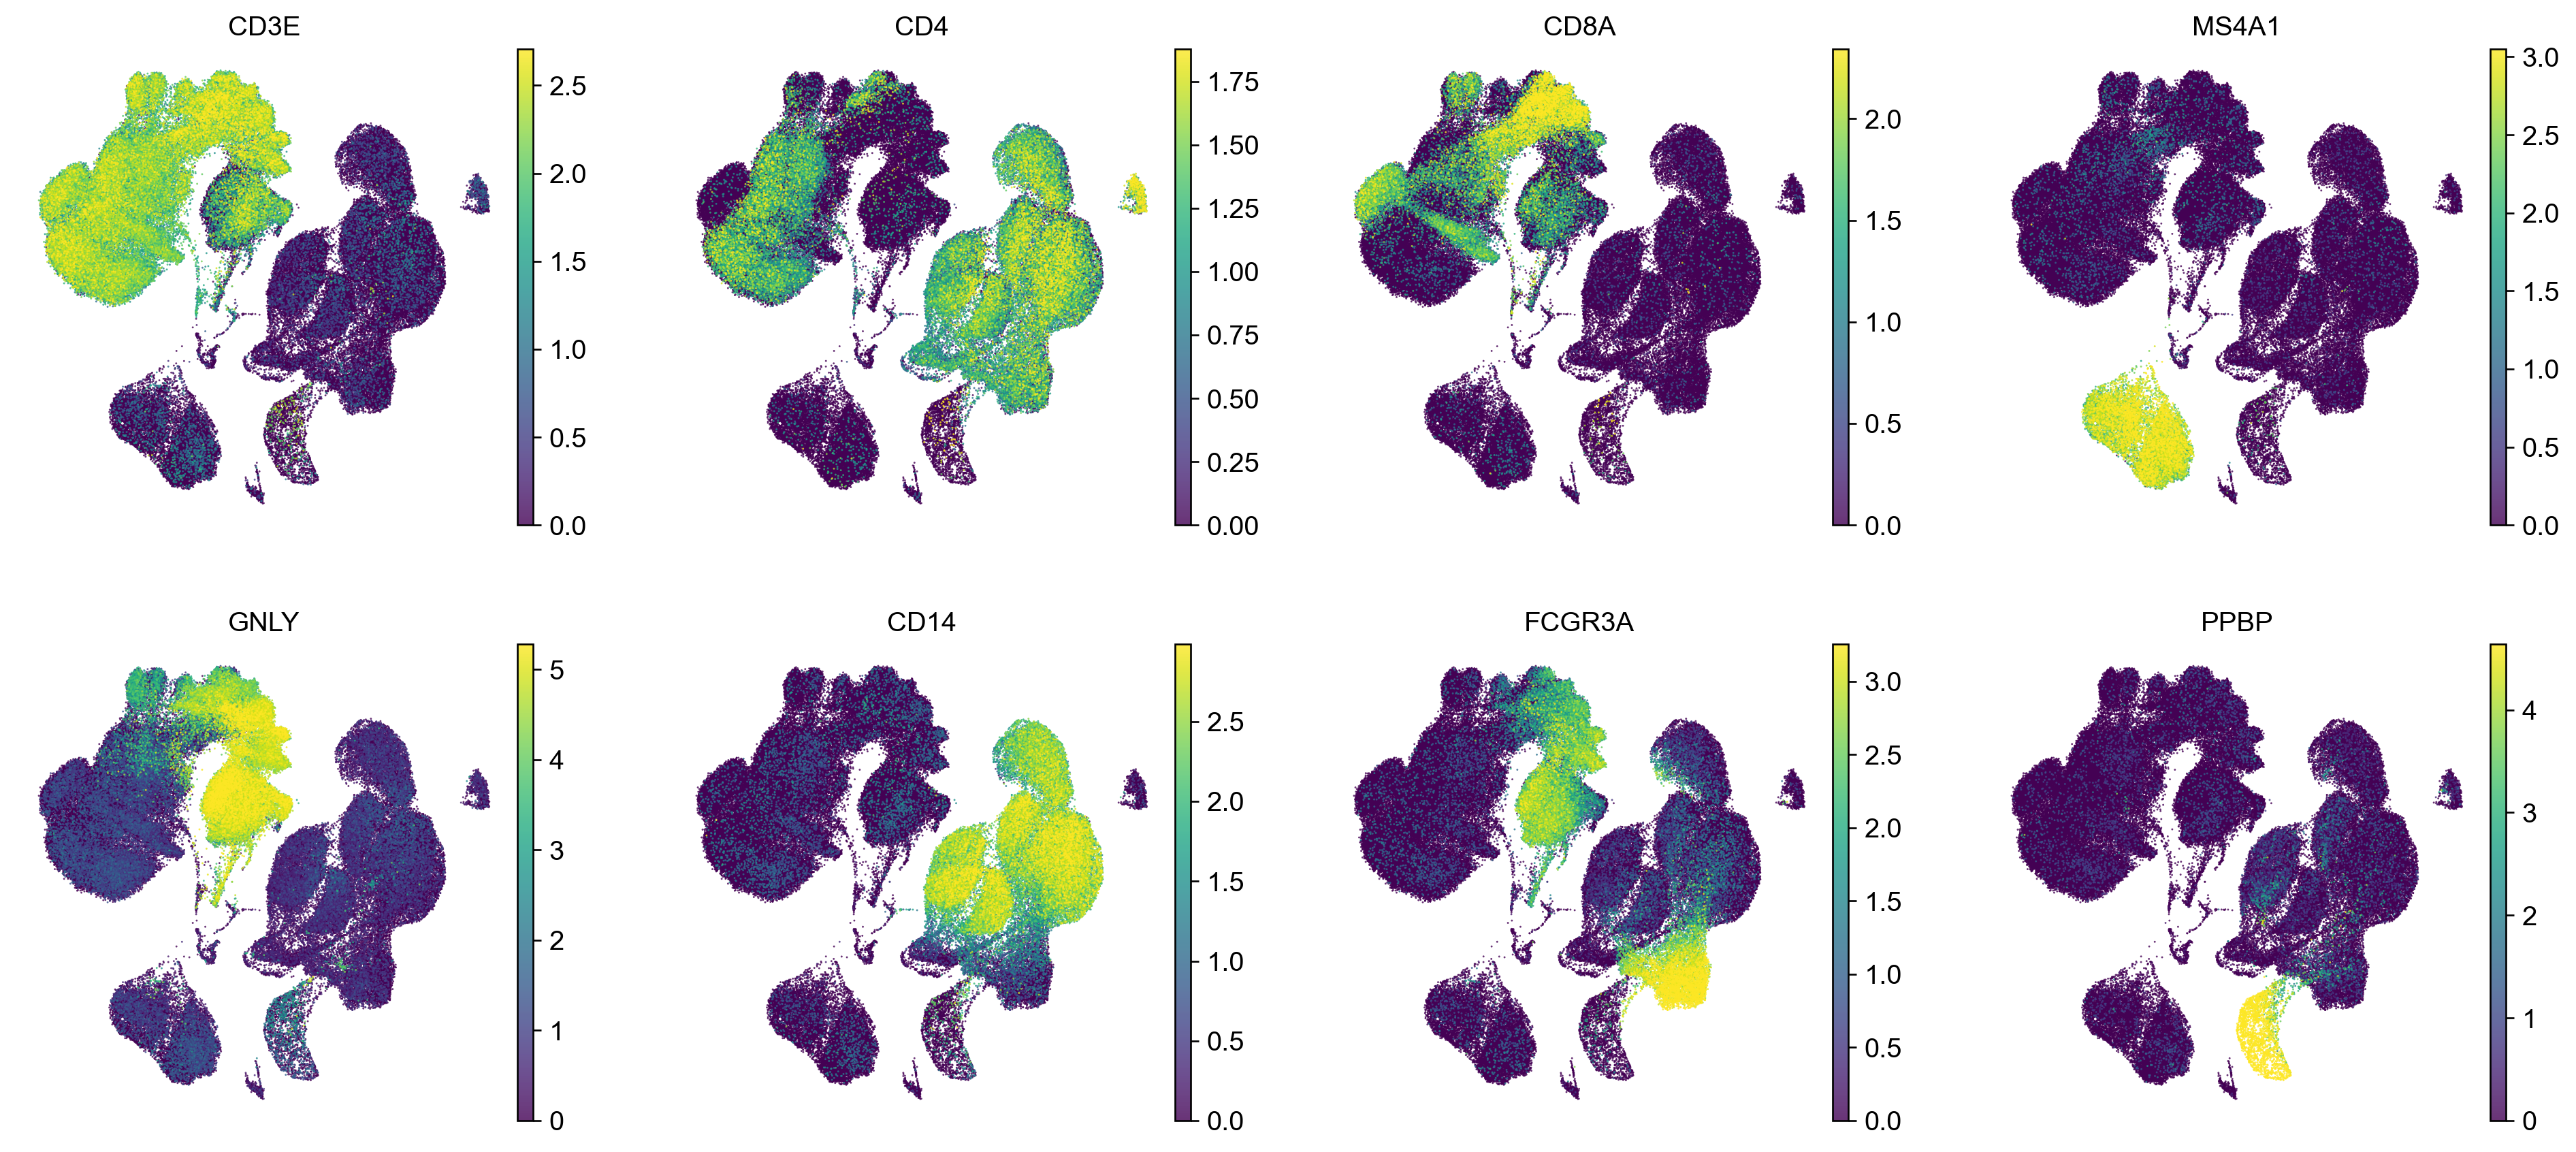

In [10]:
# Plot 4: Key Marker Genes (Example genes for PBMCs)
# Define canonical marker genes for major PBMC cell types
marker_genes = ['CD3E', 'CD4', 'CD8A', 'MS4A1', 'GNLY', 'CD14', 'FCGR3A', 'PPBP']
available_markers = [g for g in marker_genes if g in adata.raw.var_names]

# Visualize expression of marker genes across the UMAP
# use_raw=True: plot from normalized (not scaled) data for interpretable expression levels
# vmin='p1', vmax='p99': clip color scale to 1st and 99th percentiles to reduce outlier effects
sc.pl.umap(
    adata,
    color=available_markers,
    use_raw=True,      # use normalized counts from adata.raw
    s=3,
    alpha=0.8,
    cmap='viridis',    # color map for expression levels
    vmin='p1',         # minimum: 1st percentile
    vmax='p99',        # maximum: 99th percentile
    show=True          # display inline in notebook
)

## 5. Summary and Next Steps

### Analysis Summary
This notebook demonstrated a complete single-cell RNA-seq analysis workflow on the **Hao et al. (2021) Cell paper dataset**:
- ✅ Loaded 161,764 cells from the GSE164378 dataset (3' RNA-seq data)
- ✅ Performed quality control and filtered low-quality cells
- ✅ Normalized data and identified highly variable genes
- ✅ Reduced dimensionality using PCA and UMAP
- ✅ Clustered cells using the Leiden algorithm
- ✅ Visualized cell types and marker gene expression

### Key Findings
- The dataset contains diverse PBMC populations including T cells, B cells, monocytes, and NK cells
- Leiden clustering successfully identified distinct cell populations
- Marker gene expression patterns align with known cell type annotations
- The original paper's cell type annotations (celltype.l1 and celltype.l2) provide ground truth labels

### About the Multimodal Dataset
**Note**: This analysis focused on the RNA-seq modality only. The complete GSE164378 dataset includes:
- **RNA-seq**: Gene expression (analyzed in this notebook)
- **ADT (Antibody-Derived Tags)**: Surface protein expression via CITE-seq
- **HTO (Hashtag Oligonucleotides)**: Sample multiplexing tags
- **TCR sequencing**: T cell receptor sequences (for T cells)

The original paper introduced the **weighted-nearest neighbor (WNN)** method to integrate these modalities.

### Potential Next Steps
1. **Differential Expression Analysis**: Identify marker genes for each cluster using `sc.tl.rank_genes_groups()`
2. **Cell Type Annotation**: Assign biological labels to Leiden clusters using marker genes
3. **Trajectory Analysis**: Investigate differentiation pathways (e.g., monocyte-to-macrophage)
4. **Multi-modal Integration**: Load and integrate ADT (protein) data with RNA-seq using WNN or other methods
5. **Reproduce Paper Results**: Implement the WNN analysis from Hao et al. (2021)
6. **TCR Analysis**: Analyze T cell receptor diversity and clonality
7. **Save Processed Data**: Export the AnnData object for downstream analysis

### Citation
If you use this dataset in your research, please cite:

> Hao, Y., Hao, S., Andersen-Nissen, E., Mauck, W.M., Zheng, S., Butler, A., Lee, M.J., Wilk, A.J., Darby, C., Zager, M., et al. (2021). Integrated analysis of multimodal single-cell data. *Cell* 184, 3573-3587.e29. https://doi.org/10.1016/j.cell.2021.04.048

In [12]:
print(f"\nAnalysis complete!")
print(f"All visualizations displayed inline in the notebook.")

# Display basic statistics
print(f"\nDataset Statistics:")
print(f"  - Total cells analyzed: {adata.n_obs:,}")
print(f"  - Highly variable genes: {adata.n_vars:,}")
print(f"  - Number of Leiden clusters: {adata.obs['leiden'].nunique()}")
if 'celltype.l1' in adata.obs.columns:
    print(f"  - Cell type categories (L1): {adata.obs['celltype.l1'].nunique()}")
if 'celltype.l2' in adata.obs.columns:
    print(f"  - Cell type categories (L2): {adata.obs['celltype.l2'].nunique()}")

# Save processed AnnData object for use in multimodal integration notebook
# This preserves all computed results (PCA, UMAP, clusters, metadata, etc.)
output_file = RESULTS_DIR / "GSE164378_rna_processed.h5ad"
print(f"\nSaving processed RNA data to: {output_file}")
adata.write(output_file)
print(f"✅ Saved! This file can be loaded in the WNN multimodal notebook.")
print(f"   Next: Run 'wnn_multimodal_integration.ipynb' to integrate RNA + protein data")


Analysis complete!
All visualizations displayed inline in the notebook.

Dataset Statistics:
  - Total cells analyzed: 161,764
  - Highly variable genes: 1,580
  - Number of Leiden clusters: 29
  - Cell type categories (L1): 8
  - Cell type categories (L2): 31

Saving processed RNA data to: results/GSE164378/GSE164378_rna_processed.h5ad
✅ Saved! This file can be loaded in the WNN multimodal notebook.
   Next: Run 'wnn_multimodal_integration.ipynb' to integrate RNA + protein data
